In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from files
def load_data():
    XAC_1 = np.loadtxt('XAC_1.txt')
    XAC_2 = np.loadtxt('XAC_2.txt')
    XBC_1 = np.loadtxt('XBC_1.txt')
    XBC_2 = np.loadtxt('XBC_2.txt')
    stimuli1 = np.load('stimuli1.npy', allow_pickle=True).item()
    stimuli2 = np.load('stimuli2.npy', allow_pickle=True).item()
    return XAC_1, XAC_2, XBC_1, XBC_2, stimuli1, stimuli2

In [47]:
def inout(I1, I2, X, W, sig, st):
    """ Compute input and output activations. """
    N = (len(I1) + len(I2))  # Ensure compatibility with W

    in1 = 1.0 / np.exp(((I1 - X[st, 0]) / sig) ** 2)  # Similarity for s1
    in1 = in1 / np.sum(in1)  # Normalize
    in2 = 1.0 / np.exp(((I2 - X[st, 1]) / sig) ** 2)  # Similarity for s2
    in2 = in2 / np.sum(in2) # Normalize
    
    #in1 = np.exp(-((I1 - X[st, 0]) / sig) ** 2)
    #in2 = np.exp(-((I2 - X[st, 0]) / sig) ** 2)

    In = np.concatenate((in1, in2))  # Flatten into a single vector

    In = In.reshape((-1, 1))  # Reshape to match matrix multiplication
    Out = W @ In  # Compute output activations

    return In, Out


In [48]:
def prototype(alf, b, sig, XAC, XBC, P, nr, cutoff):
    """ Prototype learning model with input-output computations. """
    ns = XAC.shape[0]  # Number of stimuli
    Max = int(np.max(XAC))
    I1 = np.arange(Max + 1)
    I2 = np.arange(Max + 1)

    # Initialize weight matrix for 2 categories
    W = np.zeros((2, (Max + 1) * 2))

    # Initialize results
    T = np.zeros((nr, 4))
    mT = np.zeros(nr)

    for rep in range(nr):
        # Compute prototype for each category
        protoA = np.mean(XAC, axis=0)
        protoB = np.mean(XBC, axis=0)

        for st in range(ns):
            # Update weights for category A
            In, Out = inout(I1, I2, XAC, W, sig, st)
            WA = alf * (np.array([1, 0])[:, None] - Out) @ In.T
            W += WA

            # Update weights for category B
            In, Out = inout(I1, I2, XBC, W, sig, st)
            WB = alf * (np.array([0, 1])[:, None] - Out) @ In.T
            W += WB

        # Transfer test
        for st in range(4):
            _, Out = inout(I1, I2, P, W, sig, st)
            p = np.exp(b * Out)
            p = p[0] / np.sum(p)

            if st in [1, 2]:  # Category A
                T[rep, st] = p.item()
            else:  # Category B
                T[rep, st] = p.item()

        # Test prediction
        mT[rep] = ((T[rep, 1] - T[rep, 0]) > cutoff) and ((T[rep, 2] - T[rep, 3]) > cutoff)

    return mT, T


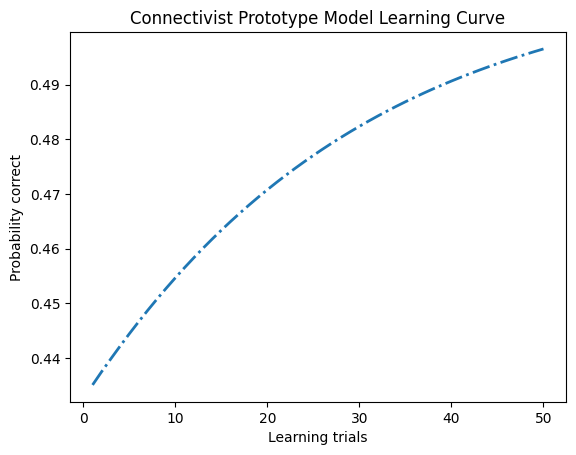

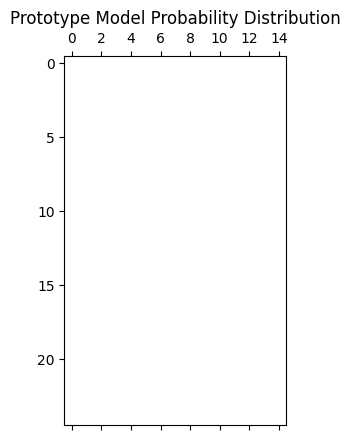

Proportion of correct patterns: 0.0


In [54]:
# Main program
def main():
    # Load data
    XAC_1, XAC_2, XBC_1, XBC_2, stimuli1, stimuli2 = load_data()
#     XAC = XAC_2  # Use stimuli 2
#     XBC = XBC_2  # Use stimuli 2
#     P = stimuli2['P']  # Ensure correct stimuli set is used

    XAC = XAC_1  # Use stimuli 1
    XBC = XBC_1  # Use stimuli 1
    P = stimuli1['P']  # Ensure correct stimuli set is used

    # Hyperparameters
    nr = 50
    aa = 25
    AV = np.arange(1, aa + 1) / aa
    bb = 15
    BV = np.arange(1, bb + 1)
    MT = np.zeros((aa, bb))
    sig = 5
    cutoff = 0.2

    # Single parameter setting
    alf = 1.0
    b = 2.5

    # Train prototype model
    Mt, Pc = prototype(alf, b, sig, XAC, XBC, P, nr, cutoff)

    # Plot learning curve
    plt.figure()
    plt.plot(range(1, nr + 1), (Pc[:, 1] + Pc[:, 2]) / 2, '-.', linewidth=2)
    plt.xlabel('Learning trials')
    plt.ylabel('Probability correct')
    plt.title('Connectivist Prototype Model Learning Curve')
    plt.show()

    # Loop through predictions for parameter sweeps
    for i in range(aa):
        for j in range(bb):
            alf = AV[i]
            b = BV[j]
            mT, _ = prototype(alf, b, sig, XAC, XBC, P, nr, cutoff)
            MT[i, j] = mT[-1]

    # Plot probability distribution
    plt.figure()
    plt.spy(MT)
    plt.title('Prototype Model Probability Distribution')
    plt.show()

    # Compute final proportion of correct patterns
    pcp = np.sum(MT == 1) / (MT.shape[0] * MT.shape[1])
    print('Proportion of correct patterns:', pcp)

if __name__ == "__main__":
    main()